In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import regex as re
import wranglerer as wr
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

# Answers to questions 1-4 and 7
### NB: answers are results of quick exploratory investigation.  Given the time-sensitive nature of the requests, more refined answers to the nuanced aspects of each question will be forthcoming.  The following represent a starting point for reporting:
---
---
---

# But first, some housekeeping:

In [2]:
# acquire the logs and create two copies, one with normal indeces and one with date indeces
df = pd.read_csv('anonymized-curriculum-access.txt',delimiter=' ',header=None)
column_names = ['date', 'time', 'page', 'user', 'cohort','ip']
df.columns =column_names
df['timestamp'] = df.date + ' ' + df.time
df_time = df
df = df.set_index('timestamp')
df = df.drop(columns=['date','time'])
df['user'] = df.user.astype('str')
df_time['user'] = df_time.user.astype('str')
df.cohort.fillna(777,inplace=True)
df_time.cohort.fillna(777,inplace=True)
df['cohort'] = df.cohort.astype('int').astype('str')
df_time['cohort'] = df_time.cohort.astype('int').astype('str')

---
# 1. Which lesson attracts most traffic across cohorts?
### Sorted lessons by the raw number of cohorts which have accessed the lesson.  Time-series analysis is forthcoming:

In [3]:
# create a dataframe grouped-by lesson, which shows a count of unique users/ip/cohorts
page_unq_df = df.groupby('page')[['user','ip','cohort']].nunique()

In [4]:
page_unq_df.sort_values('cohort',ascending=False).head(10)

,user,ip,cohort
page,,,
/,962,3366,48
search/search_index.json,701,1289,42
toc,656,1439,41
html-css,724,1205,41
javascript-i,725,1302,41
java-i,634,1057,41
appendix,615,855,40
spring,612,1035,40
mysql,592,960,39


# ANSWER: html-css, javascript-i, java-i lessons have been accessed by 41 cohorts each

---
# 2. Is there a cohort that referred to a lesson more than other cohorts?
### Sorted lessons by the raw number of cohorts which have accessed the lesson.  Also sorted lessons by the percentage of page hits which are from a particular cohort.  See below!

In [5]:
# Given a particular page, what is probability of a certain cohort
page_given_cohort = (
    df.groupby('cohort')\
    .page.value_counts(normalize=True)\
    .rename('proba_cohort_given_page')\
    .reset_index())
page_given_cohort

page_tot_by_cohort = page_given_cohort.groupby('cohort').nunique()

In [6]:
page_tot_by_cohort.sort_values('page',ascending=False).head(10)

,page,proba_cohort_given_page
cohort,,
28,1404,229
777,1112,207
22,544,148
34,533,137
14,486,86
25,421,129
59,420,148
55,418,133
23,406,151


## NB, Cohort 28 is reserved to indicate CodeUp Staff...cohort 777 is a plceholder value that indicates "No Cohort" assigned to pagehit instance.
# ANSWER: cohort 22 referenced 544 unique pages, cohort 34 referenced 533 unique pages and cohort 14 referenced 486 unique pages.  Also, cohorts 9, 4, and 139 appear to have accessed particular lessons more frequently than other cohorts, see below...

In [7]:
page_given_cohort[(page_given_cohort.proba_cohort_given_page < 1)&(
    page_given_cohort.proba_cohort_given_page >= 0.1)&(
    page_given_cohort.page != '/')].sort_values('proba_cohort_given_page',ascending=False)

,cohort,page,proba_cohort_given_page
14673,9,content/html-css,0.400000
10038,4,mkdocs/search_index.json,0.250000
10039,4,prework/databases,0.250000
10040,4,prework/versioning/github,0.250000
14675,9,content/html-css/gitbook/images/favicon.ico,0.200000
14676,9,content/html-css/introduction.html,0.200000
12532,6,javascript-ii/es6,0.138889
2190,139,javascript-i/introduction/operators,0.107057
2191,139,javascript-i/introduction/primitive-types,0.105861
2192,139,javascript-i/functions,0.102273


# ANSWER...for example, 10.7% of all page hits for "javascript-i/introduction/operators" come from COHORT 139 (Oberon)

---
# 3. Are there students who hardly access the curriculum?
### Sorted student total page hits and filtered by total number of page hits as well as total UNIQUE page hits.

In [8]:
# grab the page count, grab the unique page access (per user)
page_views = df.groupby(['user'])['page'].agg(['count','nunique'])

In [9]:
page_views[(page_views['count'] < 100)&(page_views['nunique'] > 30)]

,count,nunique
user,,
102,80,48
103,46,32
113,97,58
13,94,33
164,94,75
173,97,41
243,44,33
247,66,58
250,68,39


# ANSWER...here is a sample of students who have accessed a significant number of UNIQUE pages (> 30), however they have NOT done so with much frequency.  Further drill-down to each user pagehits over time will explain more...this is forthcoming.

---
# 4. Is there any suspiscious activity? Possible web-scraping?
###  Sorted DATES by the total number of PageHits by any SINGLE USER.  If a single user accessed many pages in a single day, this behavior would be reflected in this dataframe.

### but first, some housekeeping...

In [10]:
# create a Dataframe that captures Bolinger Bands based on a Rolling-30-day Exponentially Weighted Mean
df_time['user'] = df_time.user.astype('int')
df0 = df_time.drop(columns=['time','timestamp'])
df0['date'] = pd.to_datetime(df0['date'])
df0 = df0.set_index('date')

In [11]:
# defining some needed functions
def get_user(df,user):
    return df[df.user == user].resample('D').page.count()

def get_user_bb(user_df,user,span=30,k=3):
    ema = user_df.ewm(span=span).mean()
    std = user_df.ewm(span=span).std()
    upper_band = ema + k*std
    lower_band = ema - k*std
    bb_df = pd.concat([user_df,
                   ema,
                   upper_band,
                   lower_band], axis=1)
    bb_df.columns = ['page_count',
                 'midband',
                 'ub',
                 'lb']
    bb_df['prcnt_b'] = (bb_df.page_count - bb_df.lb) / (
    bb_df['ub'] - bb_df['lb'])
    bb_df['user_id'] = user
    return bb_df

def get_anomalies(df,user,k=3,span=30):
    user_df=get_user(df,user)
    bb_df = get_user_bb(user_df,user,span=span,k=k)
    anomalies = bb_df[bb_df.prcnt_b >= 1]
    return anomalies

In [12]:
# create a Dataframe indexed on Date which depicts Total pagehits by user_id
anom = pd.DataFrame(columns=['page_count', 'midband', 'ub', 'lb','prcnt_b','user_id'])
for i in range(1,982):
    temp_df = pd.DataFrame(get_anomalies(df0,i))
    anom = pd.concat([anom,temp_df],axis=0)
    #anom = anom.append(temp_df,ignore_index=True)

In [13]:
anom.drop(columns=['ub','lb','prcnt_b'],inplace=True)

# ANSWER...here is a sample indexed by DATE, showing total pagehits by USER.  The  "midband" column indicates a rolling 30-day Exponential Moving Average for that particular user.

In [14]:
anom

,page_count,midband,user_id
2018-02-20,54,6.456745,1
2018-05-29,68,9.612443,1
2018-11-07,13,1.221442,1
2018-12-19,25,2.880262,1
2019-01-29,44,3.623334,1
...,...,...,...
2021-04-13,42,6.722117,884
2021-04-14,67,12.322021,888
2021-04-20,53,11.548548,919
2021-04-06,14,1.170588,920


# ANSWER...the users below are the "Most-pagehits-per-day" Leaders...NB, this list shows users who are pinging over 200 pages per day...further investigation is required!

In [15]:
anom[anom['page_count'] > 200].sort_values('page_count',ascending=False)

,page_count,midband,user_id
2020-07-22,285,44.915959,11
2019-03-03,272,24.721632,341
2020-04-16,271,44.194413,570
2019-07-25,253,34.698961,422
2020-04-05,232,32.133967,570
2018-12-19,225,20.831494,313


---
# 7. Which lessons are least accessed?
###  Sorted Pages by total count of pagehits.

In [16]:
# Create dataframe showing the total count of pagehits associated with each page
page_df = pd.DataFrame(df.page.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'page', 'page': 'count'})
page_df2 = pd.DataFrame((df.page.value_counts(dropna=False))/df.page.count()).reset_index().\
                rename(columns={'index': 'page', 'page': 'proba'})
page_df = page_df.merge(page_df2, on='page')
page_df.drop(columns=['proba'],inplace=True)
page_df

,page,count
0,/,50313
1,search/search_index.json,19519
2,javascript-i,18983
3,toc,18297
4,java-iii,13733
...,...,...
2309,12-distributed-ml/6.1-prepare-part-1,1
2310,12-distributed-ml/6.4-prepare-part-4,1
2311,4-python,1
2312,4-python/overview,1



# ANSWER: Here are the 458 pages that have only been accessed 1 time...further filtering can be accomplished based upon further questions.

In [17]:
page_df[(page_df['count'] == 1)]

,page,count
1856,ml-methodologies-drawing.jpg,1
1857,javascript-i/html-css,1
1858,',1
1859,json-responses,1
1860,content/examples/git/gitbook/images/favicon.ico,1
...,...,...
2309,12-distributed-ml/6.1-prepare-part-1,1
2310,12-distributed-ml/6.4-prepare-part-4,1
2311,4-python,1
2312,4-python/overview,1


---
# 8. Anything else to be made aware of?

# User_id 570 showed up twice on the Top-5 Daily counts of pagehits list...just as with all users with over a specified threshold of daily pagehits...investigation required.

In [18]:
anom[anom['user_id'] == 570]

,page_count,midband,user_id
2020-04-05,232,32.133967,570
2020-04-16,271,44.194413,570
2020-08-10,66,7.040462,570
2021-02-08,3,0.195577,570
2021-02-11,53,3.579468,570


# Interestingly, we have 64 instances of users that have more than 100 pagehits in a single day!  Also compare the number of pagehits to the rolling 30-day Exponential Midband.

In [19]:
anom[anom['page_count'] > 100].sort_values('page_count',ascending=False)

,page_count,midband,user_id
2020-07-22,285,44.915959,11
2019-03-03,272,24.721632,341
2020-04-16,271,44.194413,570
2019-07-25,253,34.698961,422
2020-04-05,232,32.133967,570
...,...,...,...
2020-05-05,102,13.566012,564
2020-09-17,101,21.136150,699
2021-02-01,101,11.357678,750
2021-01-05,101,15.007583,796


# Here is a representation of how we can generate line graphs showing a particular user pattern of use over time (both "total count" and "total unique"...feel free to request more of these should you find them useful.

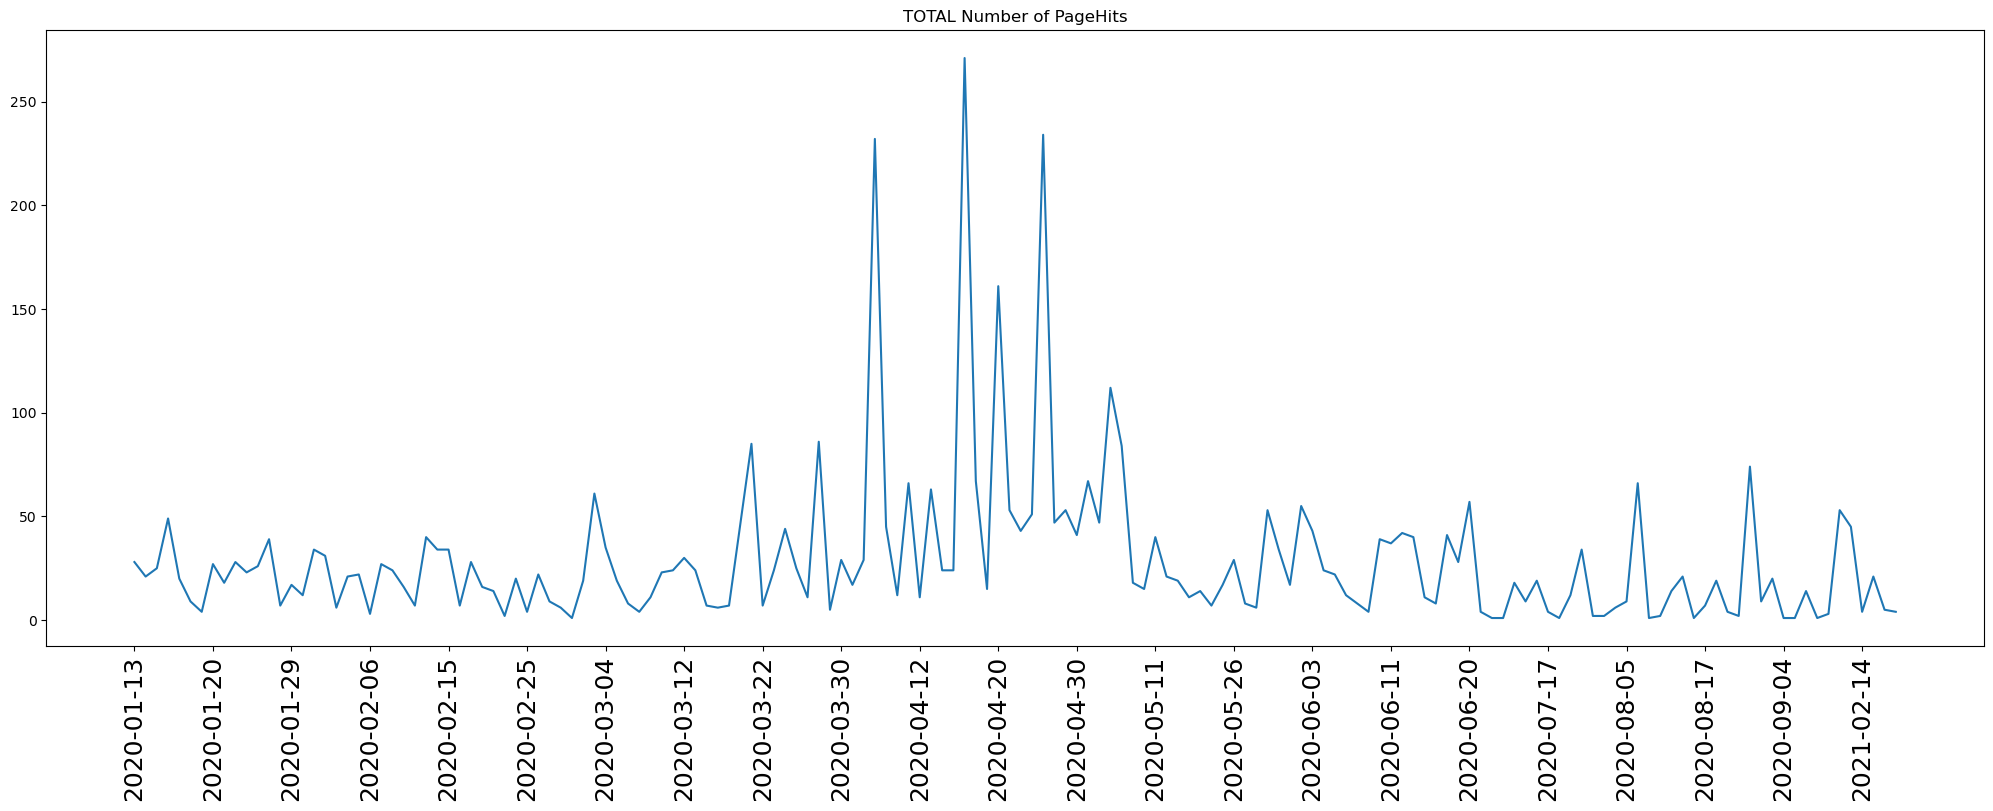

In [20]:
# Line graph to show TOTAL daily pagehits
date_df2 = df_time[df_time['user'] == 570].groupby('date')[['page']].count()


plt.figure(figsize=(25,8))
plt.plot(date_df2)
l = date_df2.index[::7]
plt.xticks(rotation=90,labels=l,ticks=l,size=18)
plt.title('TOTAL Number of PageHits')
plt.show()

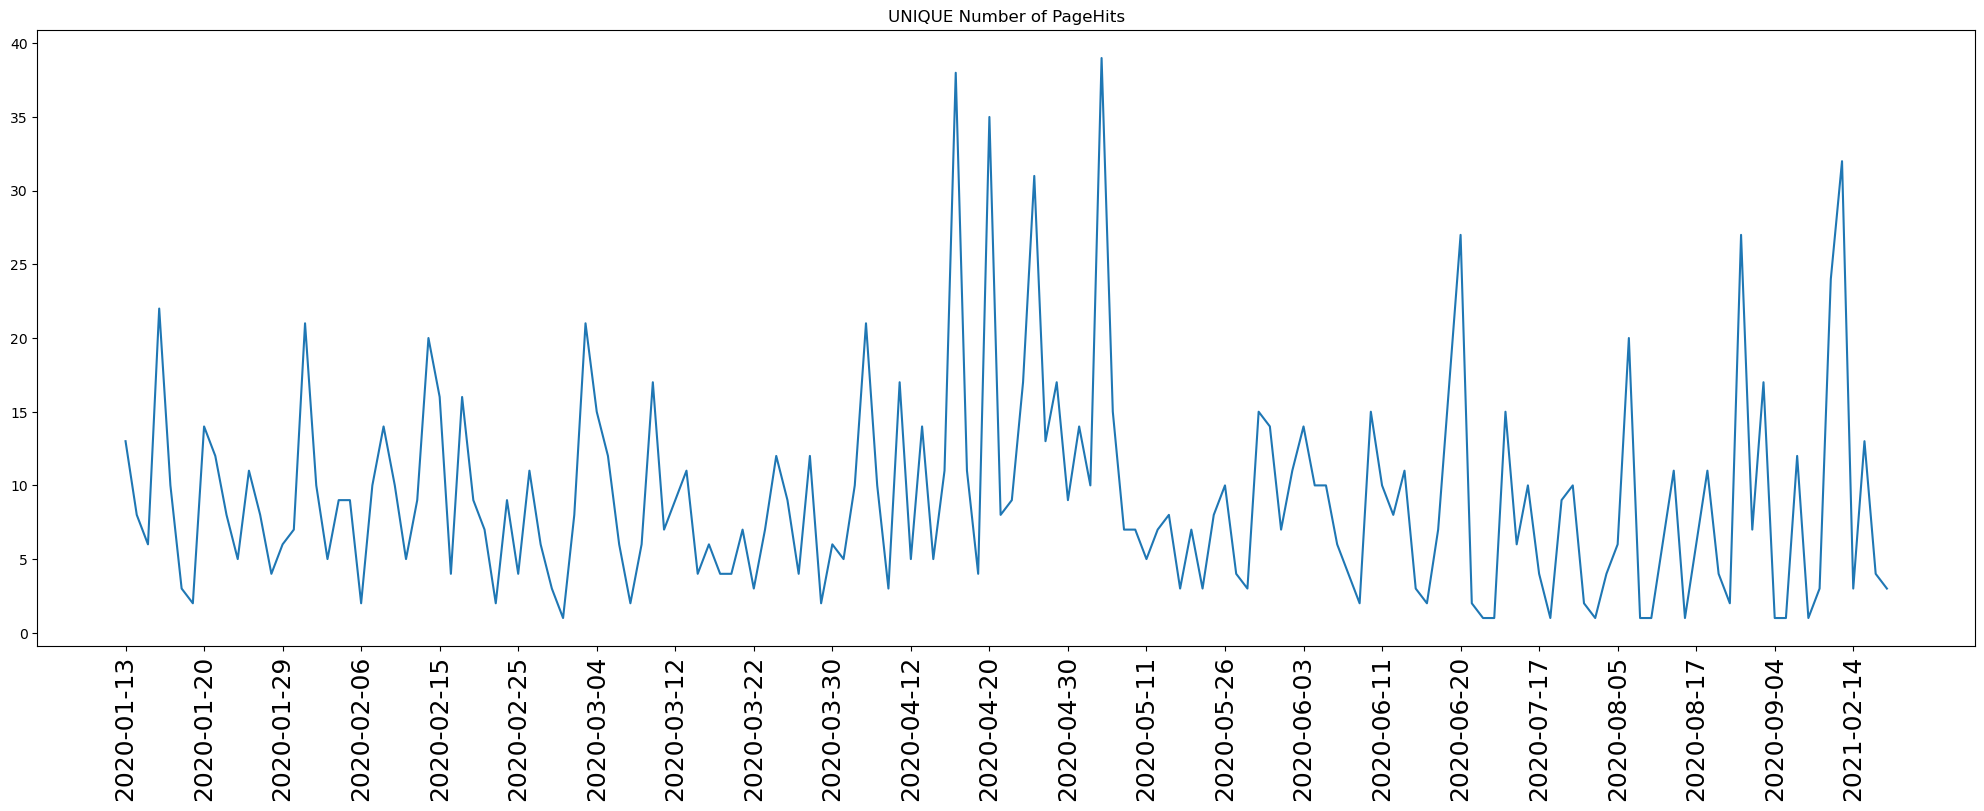

In [21]:
# Line graph to show UNIQUE daily pagehits
date_unq_df2 = df_time[df_time['user'] == 570].groupby('date')[['page']].nunique()

plt.figure(figsize=(25,8))
plt.plot(date_unq_df2)
l = date_df2.index[::7]
plt.xticks(rotation=90,labels=l,ticks=l,size=18)
plt.title('UNIQUE Number of PageHits')
plt.show()

# User_id 570 busiest day was April 16, 2020 while in Fortuna Cohort.  Activity is during the daytime (assuming timestamp is valid in Central Time Zone).  

## User 570 used 52 unique ip addresses, however, this does not place user within the Top-10 list of count of unique ip's used.

##  Mean avg for CodeUp user is 7.7 unique ip addresses used.

In [22]:
# create a dataframe for specified user 570
df570 = df[(df['user'] == '570')&(df['cohort'] == '53')]

In [23]:
# Busy day on 4-16-2020 for User 570
df570['2020-04-16':'2020-04-17']

,page,user,cohort,ip
timestamp,,,,
2020-04-16 09:58:46,toc,570,53,172.124.67.93
2020-04-16 09:58:47,toc,570,53,172.124.67.93
2020-04-16 09:59:43,mysql/clauses,570,53,172.124.67.93
2020-04-16 09:59:43,mysql/clauses,570,53,172.124.67.93
2020-04-16 09:59:58,mysql/clauses/where,570,53,172.124.67.93
...,...,...,...,...
2020-04-16 18:16:30,appendix/code-standards/java,570,53,172.124.67.93
2020-04-16 18:16:33,appendix/documentation,570,53,172.124.67.93
2020-04-16 18:16:33,appendix/documentation,570,53,172.124.67.93


In [24]:
# Unique ip addresses in use:
df570.ip.nunique()

52

In [25]:
user_unq_df = df.groupby('user')[['page','ip','cohort']].nunique()

In [26]:
# TOP 10 number of unique ip addresses...570 not in Top-10
user_unq_df.sort_values('ip',ascending=False).head(10)

,page,ip,cohort
user,,,
228,145,148,1
843,137,126,1
533,156,92,1
690,185,88,1
530,158,86,1
226,168,83,1
460,147,82,1
590,194,75,1
127,296,67,1


In [27]:
user_unq_df.ip.mean()

7.680937818552497